---
title: "Exploratory Data Analysis"

format:
    html: 
        code-fold: false
        embed-resources: true
---

{{< include EDA.qmd >}}

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

## Required Libraries

In [102]:
# import required libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
import seaborn as sns
from scipy.stats import ttest_ind

## News Data[@lecutre_content]

In this section, we will analyze media coverage of select F1 drivers who created significant buzz during the 2024 season. The drivers include **Max Verstappen**, **Carlos Sainz**, **Lando Norris**, **Daniel Riccardo**, and **Lewis Hamilton**. These drivers have been at the center of media discussions due to their performance, contract negotiations, and potential moves for the 2025 season.

In [56]:
# Function to generate a word cloud for a single JSON file
def generate_wordcloud_top_n(file_path, output_folder, top_n=10):
    # helper function to plot and save the word cloud
    def plot_cloud(wordcloud, output_file):
        plt.figure(figsize=(10, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(output_file) 

        plt.close()

    # read the text from the JSON file
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # concatenate all text content if it's a JSON dictionary
    if isinstance(data, dict):
        my_text = ' '.join(data.values())

    # generate word cloud to extract word frequencies
    wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",  
        colormap="Blues_r",  
        collocations=False,
        stopwords=STOPWORDS
    ).generate(my_text)

    # extract word frequencies and get the top N words
    word_frequencies = wordcloud.words_
    top_words = dict(list(word_frequencies.items())[:top_n])

    # generate a new word cloud with only the top N words
    top_wordcloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",  
        colormap="Blues_r",
        collocations=False,
        stopwords=STOPWORDS
    ).generate_from_frequencies(top_words)

    # Save and display the word cloud
    file_name = os.path.basename(file_path).replace('.json', '_wordcloud.png')
    output_file = os.path.join(output_folder, file_name)
    plot_cloud(top_wordcloud, output_file)


# function to process all JSON files in a folder
def generate_wordclouds_for_folder(input_folder, output_folder, top_n=10):
    os.makedirs(output_folder, exist_ok=True)  
    # loop through all files in the input folder
    for file_name in os.listdir(input_folder):
        # process only JSON files
        if file_name.endswith('.json'):  
            file_path = os.path.join(input_folder, file_name)
            try:
                generate_wordcloud_top_n(file_path, output_folder, top_n)
            # for debugging purpose
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")


In [57]:
input_folder = "../../data/processed-data/News_Drivers/" 
output_folder = "../../data/eda/WordClouds/"  
generate_wordclouds_for_folder(input_folder, output_folder, top_n=20)

{{< include WordClouds.qmd >}}

## Drivers' Performance

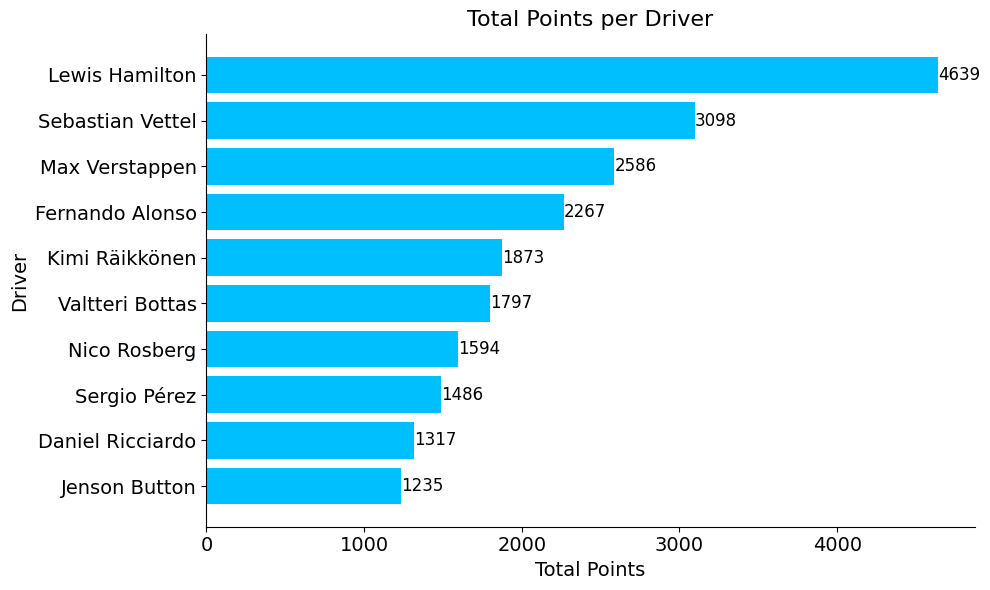

In [44]:
# number of points by driver
data = pd.read_csv("../../data/processed-data/driver_standings_2000_2023.csv")
# Calculate total points for each driver
total_points = data.groupby("driverName")["Points"].sum().reset_index()

# plot only top 10 drivers 
top_10_drivers = total_points.sort_values(by="Points", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_drivers["driverName"], top_10_drivers["Points"], color="deepskyblue")

for bar in bars:
    plt.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center', fontsize=12, color='black'
    )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Total Points", fontsize=14)
plt.ylabel("Driver", fontsize=14)
plt.title("Total Points per Driver", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Insights: 

- The cumulative points reflect a driver's career longevity, performance, and overall success in the psport
- **Lewis Hamilton** stands out as the clear leader with 4,630 points, significantly ahead of other drivers. This highlights his dominance in the sport over the years, attributed to his consistent race wins, and career with top teams like McLaren and Mercedes in their eras. 
- **Sebastian Vettel** holds the second spot with 3,098 points, his performance in Red Bull and Ferrari might have significant contribution to these numbers, since his early years in Sauber, and Toro Rosso, and his performance in Aston Martin were not as successful.
- **Max Verstappen** has the third highest cumulative total despite entering the sport relatively later. His rapid accumulation of points in the recent years underscores his dominance in the current era of F1.


In [58]:
# points scored by driver over time with different teams
def plot_driver_points(data, driver_name, color_list=None):

    # filter the data to include only the specified driver
    # sort by season
    driver_data = data[data['driverName'] == driver_name].sort_values(by='Season')
    # list of unique constructors the driver raced for 
    unique_constructors = driver_data["Constructor_Name"].unique()
    # assign colors to constructors 
    if color_list:
        constructor_colors = {
            constructor: color_list[i % len(color_list)]
            for i, constructor in enumerate(unique_constructors)
        }
    else:
        constructor_colors = {
            constructor: plt.cm.tab10(i / len(unique_constructors))
            for i, constructor in enumerate(unique_constructors)
        }
    plt.figure(figsize=(10, 6))

    # line plot
    for i in range(len(driver_data) - 1):
        season_start = driver_data.iloc[i]['Season']
        season_end = driver_data.iloc[i + 1]['Season']
        points_start = driver_data.iloc[i]['Points']
        points_end = driver_data.iloc[i + 1]['Points']
        constructor = driver_data.iloc[i]['Constructor_Name']
        

        plt.plot(
            [season_start, season_end],
            [points_start, points_end],
            color=constructor_colors[constructor],
            linewidth=4
        )
    

    for _, row in driver_data.iterrows():
        plt.text(row['Season'], row['Points'], str(row['Points']), fontsize=12, ha='center')
    

    plt.title(f"Points Over Seasons for {driver_name}", fontsize=16)
    plt.xticks(fontsize = 14, rotation = 90)
    plt.yticks(fontsize = 14)
    plt.xlabel("Season", fontsize=14)
    plt.ylabel("Points", fontsize=14)
    plt.tight_layout()
    plt.xticks(range(int(driver_data["Season"].min()), int(driver_data["Season"].max()) + 1))


    legend_elements = [
        mlines.Line2D([], [], color=constructor_colors[constructor], label=constructor, linewidth=3)
        for constructor in unique_constructors
    ]
    plt.legend(handles=legend_elements, loc="upper left", fontsize=14)
    

    plt.show()

color_list = ["lightskyblue", "cornflowerblue", "deepskyblue", "powderblue", "steelblue", "lightblue"]


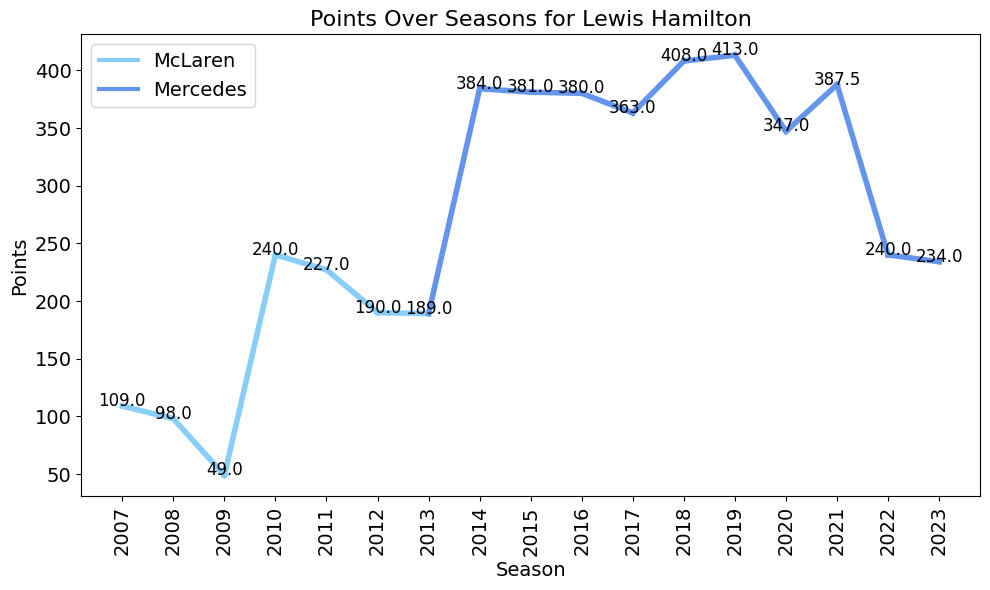

In [63]:
plot_driver_points(data, "Lewis Hamilton", color_list)

{{< include points_driver.qmd >}}

## Constructors' Performance

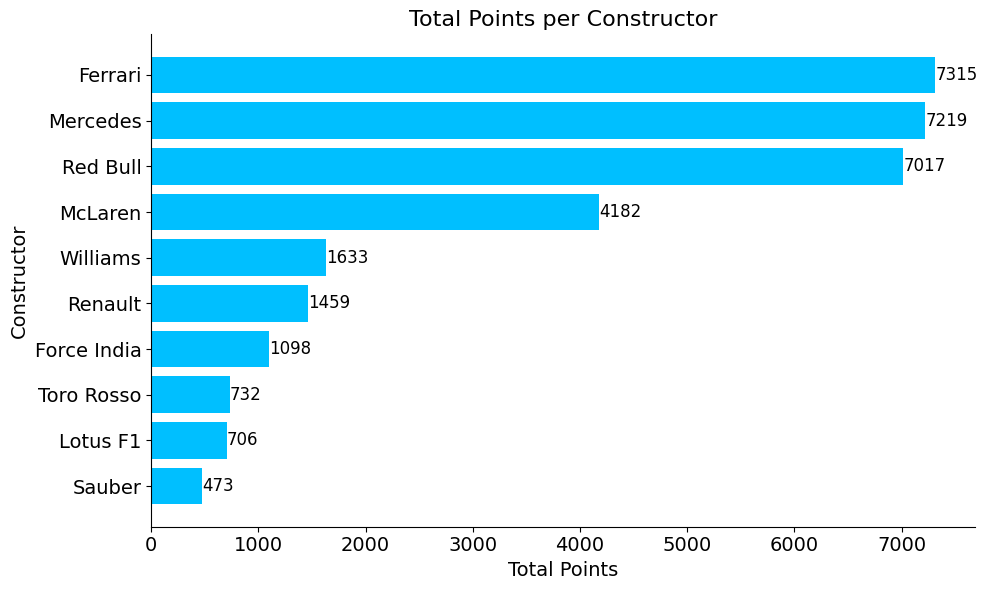

In [69]:
total_points = data.groupby("Constructor_Name")["Points"].sum().reset_index()


constructors = total_points.sort_values(by="Points", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(constructors["Constructor_Name"], constructors["Points"], color="deepskyblue")

for bar in bars:
    plt.text(
        bar.get_width() + 1, 
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}',  
        va='center', fontsize=12, color='black'
    )
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Total Points", fontsize=14)
plt.ylabel("Constructor", fontsize=14)
plt.title("Total Points per Constructor", fontsize=16)
plt.gca().invert_yaxis()  
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


Insights:

-	The top 3 teams – Ferrari, Mercedes, and Red Bull – are closely positioned in the cumulative points standings. 
-	Mercedes’ position is particularly notable because they re-entered the sports as a constructor in 2010, while Ferrari and Red Bull have accumulated points across the full 2000-2023 period. Despite the sorter timeframe, Mercedes managed to secure the second position, showcasing their unparalleled dominance 2014 onward.
-	From domain knowledge, a key differentiating factor for Mercedes has been the consistent performance of their drivers, such as Lewis Hamilton, Nico Rosberg, and Valtteri Bottas, who regularly secured podium finishes during their tenure. This level of consistency has allowed Mercedes to close the gap with Ferrari and Red Bull in a relatively short period. 
-	For Ferrari and Red Bull, the points reflect their long-standing success and ability to remain competitive across different eras. Ferrari's consistent presence at the top, coupled with Red Bull's dominance during Sebastian Vettel's era (2010-2013) and Max Verstappen's current reign, has solidified their positions in the top three


In [79]:
# distribution of "Lapped", "Mechanical", "Accident" across Constructors
data = pd.read_csv("../../data/processed-data/race_info.csv")


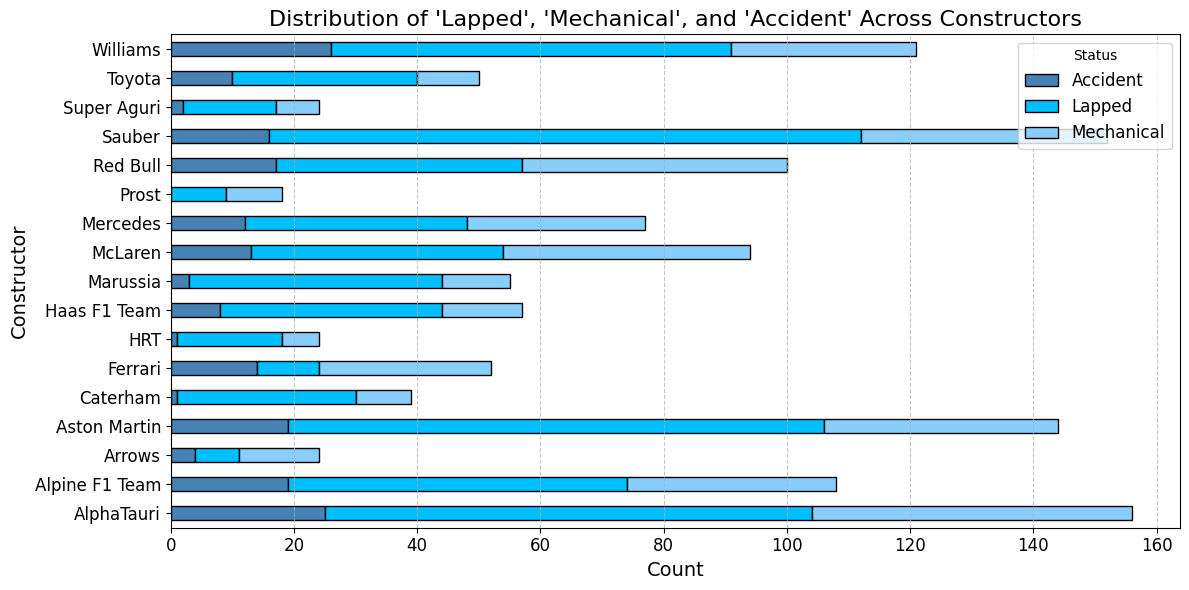

In [72]:
# Filter the data for specific statuses
filtered_data = data[data["status"].isin(["Lapped", "Mechanical", "Accident"])]

# Group by constructor and status to get counts
status_distribution = filtered_data.groupby(["constructorName", "status"]).size().unstack(fill_value=0)

# Plot the distribution as a stacked horizontal bar chart
status_distribution.plot(
    kind="barh",
    figsize=(12, 6),
    color=['steelblue', 'deepskyblue', 'lightskyblue'],  
    edgecolor="black",
    stacked=True 
)

# Customize the plot
plt.title("Distribution of 'Lapped', 'Mechanical', and 'Accident' Across Constructors", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Constructor", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Status", fontsize=12, loc="upper right")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


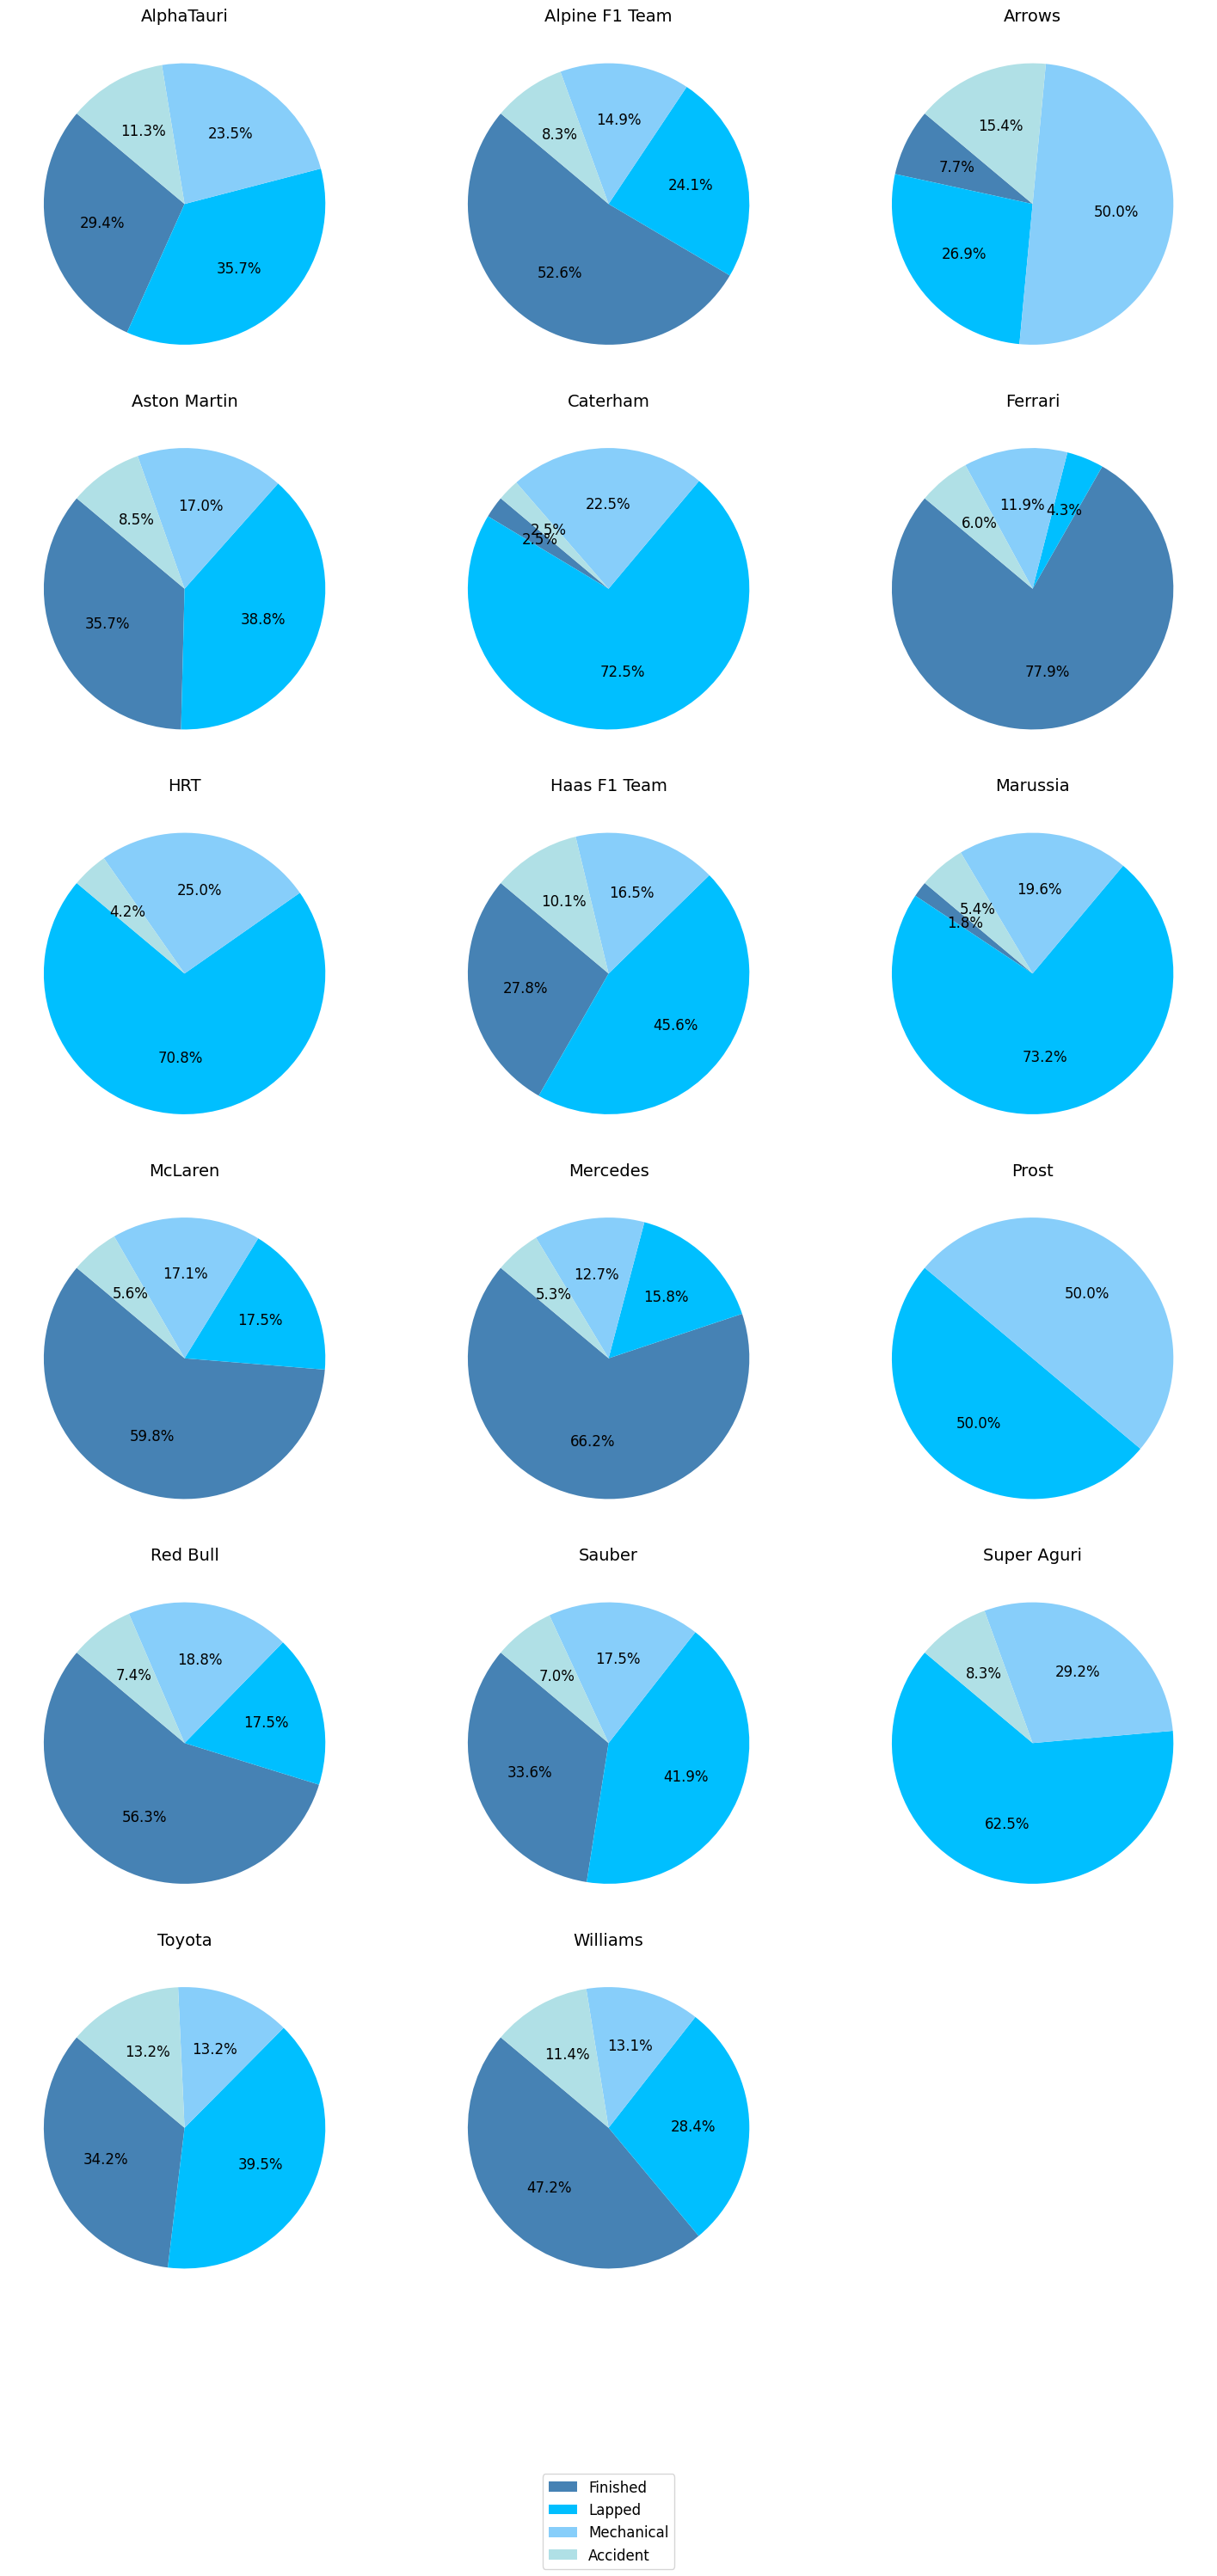

In [76]:
# distrbution of status for each constructor 
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

filtered_data = data[data["status"].isin(["Finished", "Lapped", "Mechanical", "Accident"])]
# Group by constructor and status to get counts
status_distribution = filtered_data.groupby(["constructorName", "status"]).size().unstack(fill_value=0)
# total number of entries per constructor
status_distribution["Total"] = data.groupby("constructorName").size()
# total number of constructors
num_constructors = len(status_distribution)
# for subplot
num_cols = 3
num_rows = (num_constructors + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

colors = ['steelblue', 'deepskyblue', 'lightskyblue', 'powderblue']
# loop through each constructor and create a pie chart
for idx, constructor in enumerate(status_distribution.index):
    # extract status counts for each constructor
    status_counts = status_distribution.loc[constructor, ["Finished", "Lapped", "Mechanical", "Accident"]]
    total_count = status_distribution.loc[constructor, "Total"]
    # calcuate percentage for each status
    percentages = (status_counts / total_count) * 100


    wedges, texts, autotexts = axes[idx].pie(
        percentages,
        labels=None,  
        autopct=autopct_format,
        colors=colors,
        startangle=140,
        textprops={'fontsize': 14} 
    )
    axes[idx].set_title(f"{constructor}", fontsize=14)

    for autotext in autotexts:
        autotext.set_fontsize(12)  


for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Add a shared legend
fig.legend(
    labels=["Finished", "Lapped", "Mechanical", "Accident"],
    loc="lower center",
    ncol=1,
    fontsize=12
)

plt.tight_layout(rect=[0, 0.1, 1, 1])  
plt.show()


Insights:

-	Ferrari stands out with an impressive 77.9% race completion rate. The low percentage of mechanical failures and lapped races further emphasize their ability to build durable and reliable cars. Mercedes also displays as a high completion rate (66.2%) and a low percentage of mechanical failures and accidents. McLaren is a close third with 59.8% finished races, although it has low percentage of accidents, it has comparatively high percentage of lapped and incomplete races due to mechanical failures out of the top 3. 
-	Williams, a team with a glorious past, shows 47.2% completion rate and 28.4% lapped races, highlighting the shift in their performance over the years. Having 11.4% accidents indicates that the drivers have not been performing well, 13.1% mechanical failures indicates struggles with car development, limited resources, and their current inability to compete with the top teams. 
-	Haas F1 Team a relatively new entrant, records 27.8% completion rate, with notable lapped races (45.6%) and mechanical failures. Their results reflect the challenges faced by newer teams with smaller budgets and sponsorships.
-	Midfield and smaller teams face significant challenges in maintaining consistency due to resource limitations, budget caps, and the learning curve required to compete at the highest level. These teams often serve as development platforms for young drivers transitioning from F2 to F1 but struggle to compete with top constructors. 


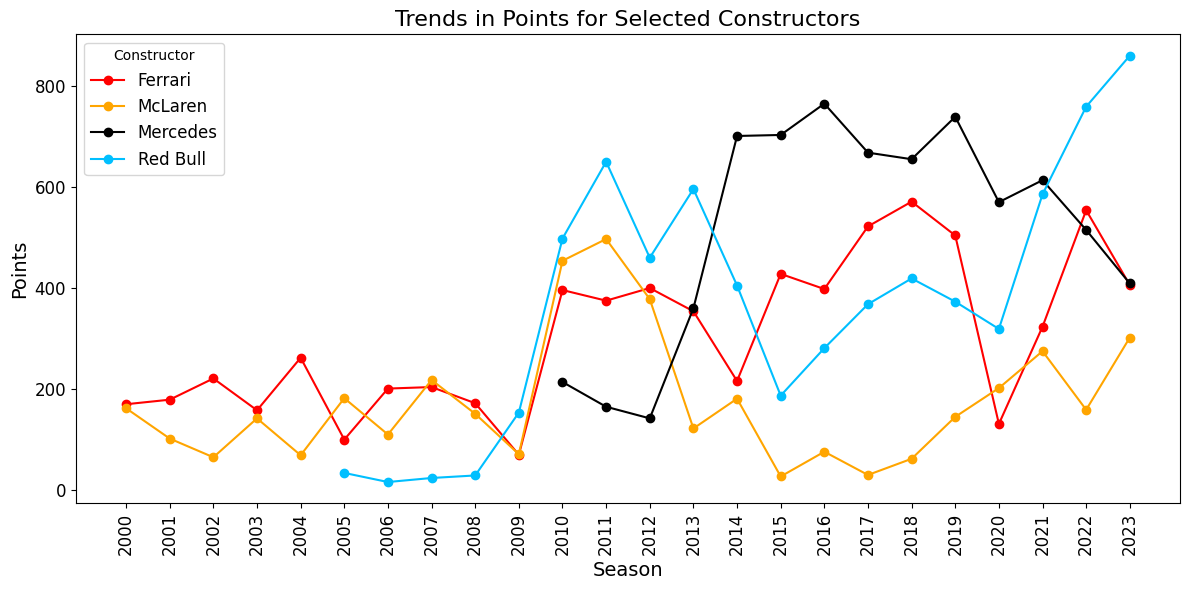

In [77]:
# trends in teams scoring points across seasons - for "Red Bull", "Ferrari", "McLaren", "Mercedes"
data = pd.read_csv("../../data/processed-data/driver_standings_2000_2023.csv")

filtered_data = data[data["Constructor_Name"].isin(["Red Bull", "Ferrari", "McLaren", "Mercedes"])]

grouped_data = filtered_data.groupby(["Season", "Constructor_Name"])["Points"].sum().unstack()

color_list = ["red", "orange", "black", "deepskyblue"]

unique_constructors = grouped_data.columns
constructor_colors = {constructor: color_list[i % len(color_list)] for i, constructor in enumerate(unique_constructors)}


plt.figure(figsize=(12, 6))
for constructor in grouped_data.columns:
    plt.plot(
        grouped_data.index, 
        grouped_data[constructor], 
        marker='o', 
        label=constructor, 
        color=constructor_colors[constructor]
    )


plt.title("Trends in Points for Selected Constructors", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Points", fontsize=14)
plt.xticks(grouped_data.index, rotation=90, fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(title="Constructor", fontsize=12)
plt.tight_layout()


plt.show()

Insights:

- The plot highlights clear periods of highs and lows for each team, emphasizing the dynamic nature of Formula 1. Success in the sport is cyclical, with teams experiencing periods of dominance followed by rebuilding phases.
- Red Bull showed a rapid rise starting in 2009, coinciding with their dominance during the Sebastian Vettel era (2010–2013). After a slight dip between 2014–2020, they have experienced another significant upward trend, driven by Max Verstappen’s dominance in recent years.
- Mercedes entered the sport as a constructor in 2010 and saw rapid progress starting in 2014 during the hybrid engine era, where they dominated for nearly a decade. Their decline starting in 2021 coincides with the resurgence of Red Bull and highlights challenges in adapting to regulation changes.
- Ferrari has experienced the most noticeable highs and lows among the teams. A steep decline is observed in 2020, likely due to car performance struggles, followed by a sharp recovery in 2022, marking their return to competitiveness.
- McLaren had strong results in the early 2000s but faced a significant decline after 2012, struggling during the hybrid era. Their gradual recovery post-2018, reflected in the upward trend, signals improvements in car performance and team structure.
- This analysis underscores that success in Formula 1 is not just about driver skill but also hinges on the ability of teams to innovate, adapt, and build competitive cars under constantly evolving technical regulations.


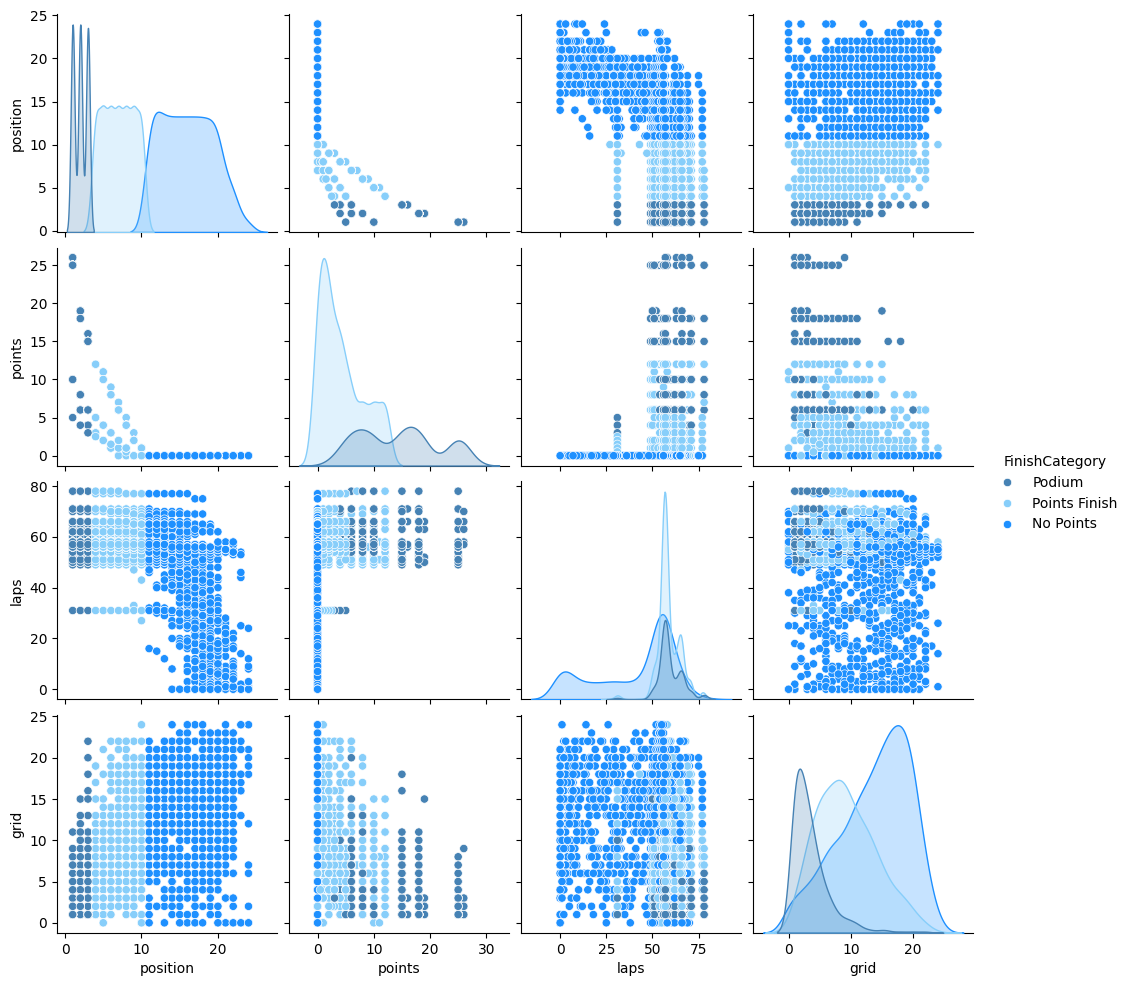

In [80]:
sns.pairplot(data[['position', 'points', 'laps', 'grid', 'FinishCategory']], hue='FinishCategory', palette={'Podium':'steelblue', 'Points Finish':'lightskyblue', 'No Points': 'dodgerblue'})

## Circuit Features

In [98]:
data = pd.read_csv("../../data/processed-data/race_track_features.csv")

In [107]:
# Full Throttle (%) vs Number of Straights

#  grouping based on the median of 'Number of Straights'
median_straights = data['Number of Straights'].median()

# tracks with fewer straights than median
low_straights = data[data['Number of Straights'] < median_straights]['Full Throttle (%)']
# tracks with >= median straights
high_straights = data[data['Number of Straights'] >= median_straights]['Full Throttle (%)']

# perform t-test
t_stat, p_value = ttest_ind(low_straights, high_straights, nan_policy='omit')

# resutls
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 8.7778
P-Value: 0.0000


There is a significant difference in Full Throttle (%) between tracks with low and high straights.

In [108]:
# Full Throttle (%) vs Number of Corners

median_corners = data['Number of Corners'].median()

# tracks with lower number of corners than median
low_corners = data[data['Number of Corners'] < median_corners]['Full Throttle (%)']
# tracks with >= median corners
high_corners = data[data['Number of Corners'] >= median_corners]['Full Throttle (%)']

# perform t-test
t_stat, p_value = ttest_ind(low_corners, high_corners, nan_policy='omit')

# results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 6.8204
P-Value: 0.0000


There is a significant difference in Full Throttle (%) between tracks with low and high corners.

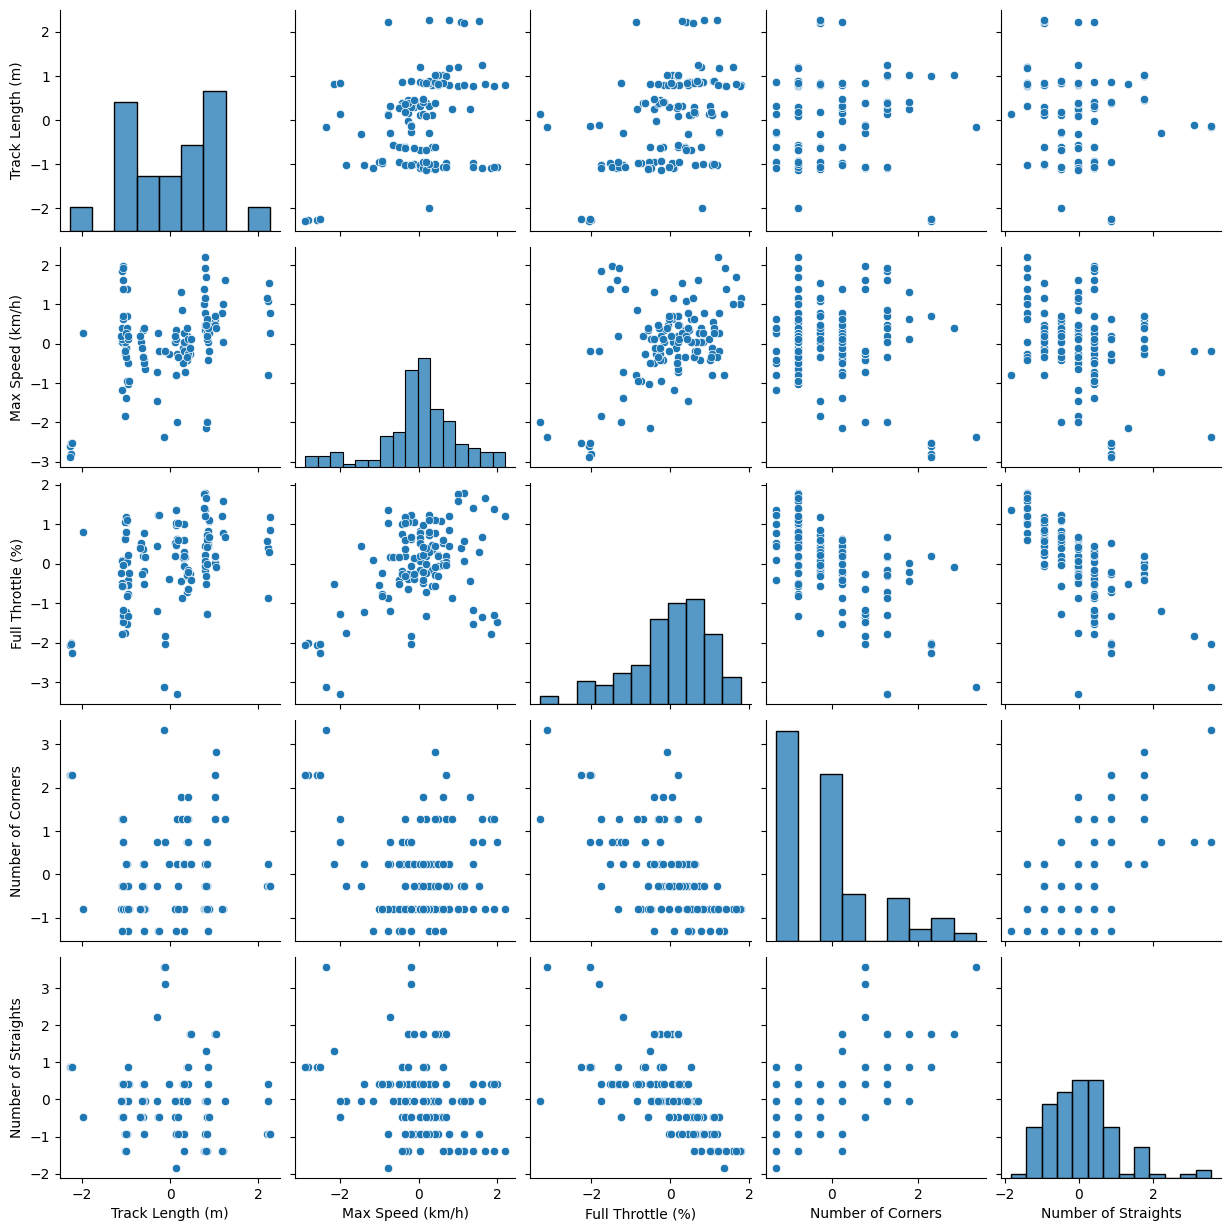

In [4]:
sns.pairplot(data[["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)","Number of Corners", "Number of Straights"]])
plt.show()

In [109]:
corr_matrix = data[["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)","Number of Corners", "Number of Straights"]].corr()
corr_matrix

,Track Length (m),Max Speed (km/h),Full Throttle (%),Number of Corners,Number of Straights
Track Length (m),1.000000,0.373616,0.399017,-0.058163,-0.118008
Max Speed (km/h),0.373616,1.000000,0.462422,-0.246056,-0.281559
Full Throttle (%),0.399017,0.462422,1.000000,-0.654084,-0.667532
Number of Corners,-0.058163,-0.246056,-0.654084,1.000000,0.631757
Number of Straights,-0.118008,-0.281559,-0.667532,0.631757,1.000000


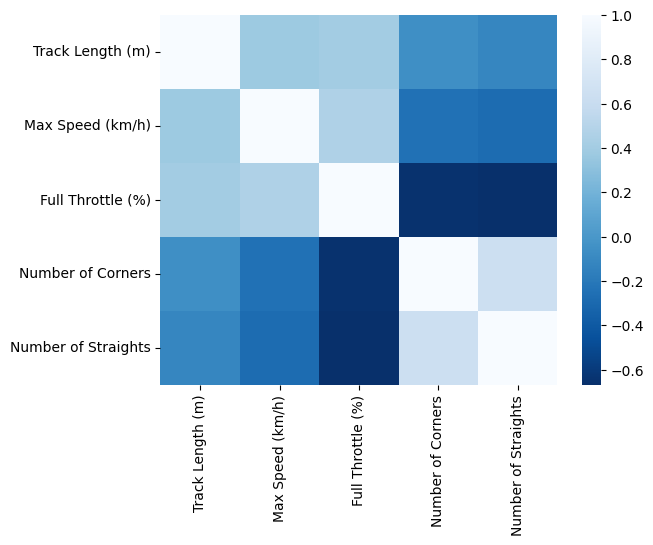

In [110]:
sns.heatmap(corr_matrix, cmap="Blues_r")
plt.show()

## Pitstop Analysis

In [113]:
data = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
data.head()

,Unnamed: 0,Year,Round,RaceName,DriverID,Lap1,Lap2,Lap3,Lap4,Lap5,...,Duration1,Duration2,Duration3,Duration4,Duration5,Duration6,Duration7,constructorName,position,grid
0,0,2011,1,Australian Grand Prix,alguersuari,-1.492522,-0.208201,1.339923,-0.281099,-0.15023,...,0.471224,0.733521,1.882538,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,11.0,12.0
1,1,2011,1,Australian Grand Prix,alonso,-0.414215,0.355923,1.723412,-0.281099,-0.15023,...,-0.122753,0.755727,1.679973,-0.277274,-0.130754,-0.060017,-0.01976,Ferrari,4.0,5.0
2,2,2011,1,Australian Grand Prix,ambrosio,-0.218159,0.976458,-0.577525,-0.281099,-0.15023,...,0.204284,0.896614,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,Marussia,14.0,22.0
3,3,2011,1,Australian Grand Prix,barrichello,-0.316187,0.130273,0.956433,3.039918,-0.15023,...,-0.058909,1.835036,0.998617,3.860649,-0.130754,-0.060017,-0.01976,Williams,16.0,17.0
4,4,2011,1,Australian Grand Prix,buemi,-0.120131,0.468747,-0.577525,-0.281099,-0.15023,...,0.217802,0.621420,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,8.0,10.0


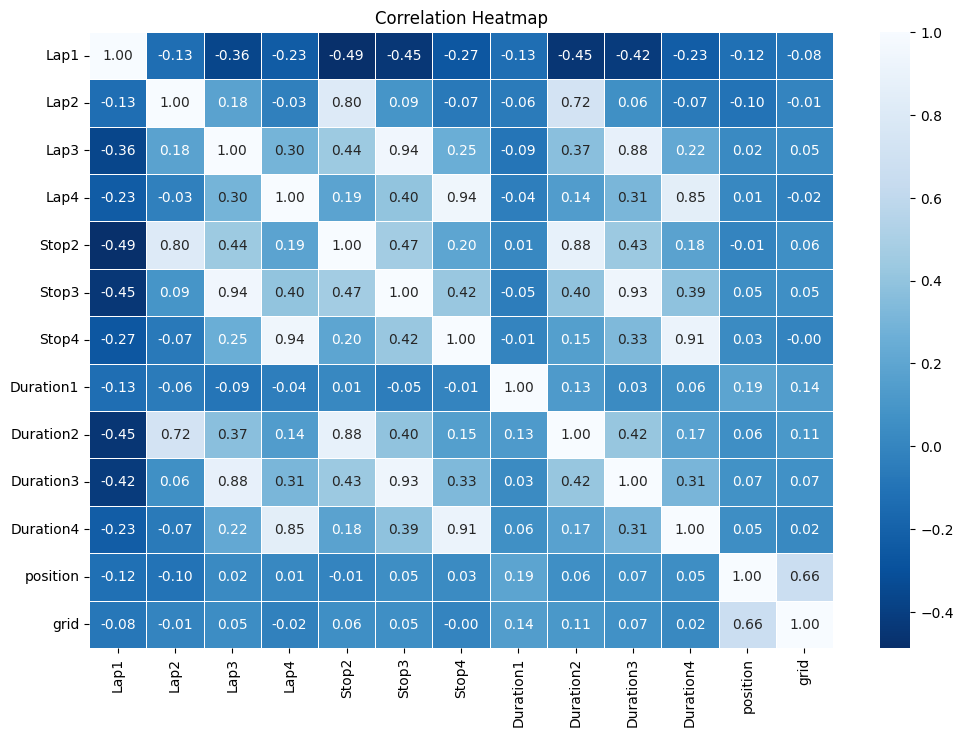

In [117]:
numerical_columns = ["Lap1", "Lap2", "Lap3", "Lap4", "Stop2", "Stop3", "Stop4",
                     "Duration1", "Duration2", "Duration3", "Duration4", "position", "grid"]
correlation_data = data[numerical_columns]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues_r", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Some of the cell outputs were excluded from the main page. They can be found [here](https://github.com/dsan-5000/project-NandiniKodali988/tree/main/data/eda)